## test

In [1]:
import numpy as np
try:
    from matplotrender.src.matplotrender import *
except:
    #!pip install git+https://github.com/chacorp/matplotrender.git
    from matplotrender import *
    
from utils.ict_face_model import ICT_face_model
from utils.util import *

# import meshplot as mp

In [2]:
src_mesh = EasyDict()

src_mesh.v, src_mesh.f = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
print('\t src vertices:', src_mesh.v.shape, '\t faces:', src_mesh.f.shape) # (11248, 3) (22288, 3)


	 src vertices: (11248, 3) 	 faces: (22288, 3)


In [3]:
src_mesh.f 

array([[  873,    11,   870],
       [  870,    11,  1492],
       [   17,  1189,  1190],
       ...,
       [11154, 11039, 11040],
       [11155, 11043, 11039],
       [11156,  9679, 11043]])

In [4]:
# print(src_mesh.v.min(0), src_mesh.v.max(0))


# large cube
control_mesh = EasyDict()
# quad mesh
control_mesh.f = np.array([
    [0,2,3,1],
    [0,1,5,4],
    [1,3,7,5],
    [3,2,6,7],
    [2,0,4,6],
    [5,7,6,4],
])
# make triangle great again 
control_mesh.f = control_mesh.f[:,[[3,2,1],[3,1,0]]].reshape(-1, 3)

control_mesh.v = np.zeros((8,3))

## X, Y, Z
control_mesh.v[0] = src_mesh.v.max(0)
control_mesh.v[1,0], control_mesh.v[1,1], control_mesh.v[1,2] = src_mesh.v.max(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[2,0], control_mesh.v[2,1], control_mesh.v[2,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[3,0], control_mesh.v[3,1], control_mesh.v[3,2] = src_mesh.v.min(0)[0], src_mesh.v.max(0)[1], src_mesh.v.min(0)[2]

control_mesh.v[4,0], control_mesh.v[4,1], control_mesh.v[4,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[5,0], control_mesh.v[5,1], control_mesh.v[5,2] = src_mesh.v.max(0)[0], src_mesh.v.min(0)[1], src_mesh.v.min(0)[2]
control_mesh.v[6,0], control_mesh.v[6,1], control_mesh.v[6,2] = src_mesh.v.min(0)[0], src_mesh.v.min(0)[1], src_mesh.v.max(0)[2]
control_mesh.v[7] = src_mesh.v.min(0)

# control_mesh.v[:,1]=control_mesh.v[:,1]*1.05
control_mesh.v=control_mesh.v*1.1


control_mesh_v2 = control_mesh.v.copy()
control_mesh_v2[0:4, 0] = control_mesh_v2[0:4, 0]+0.8

control_mesh_v3 = control_mesh.v.copy()
control_mesh_v3[0:4, 1] = control_mesh_v3[0:4, 1]+0.5

control_mesh_v4 = control_mesh.v.copy()
control_mesh_v4[0:4, 0] = control_mesh_v4[0:4, 0]-0.4
control_mesh_v4[0:4, 1] = control_mesh_v4[0:4, 1]-0.5

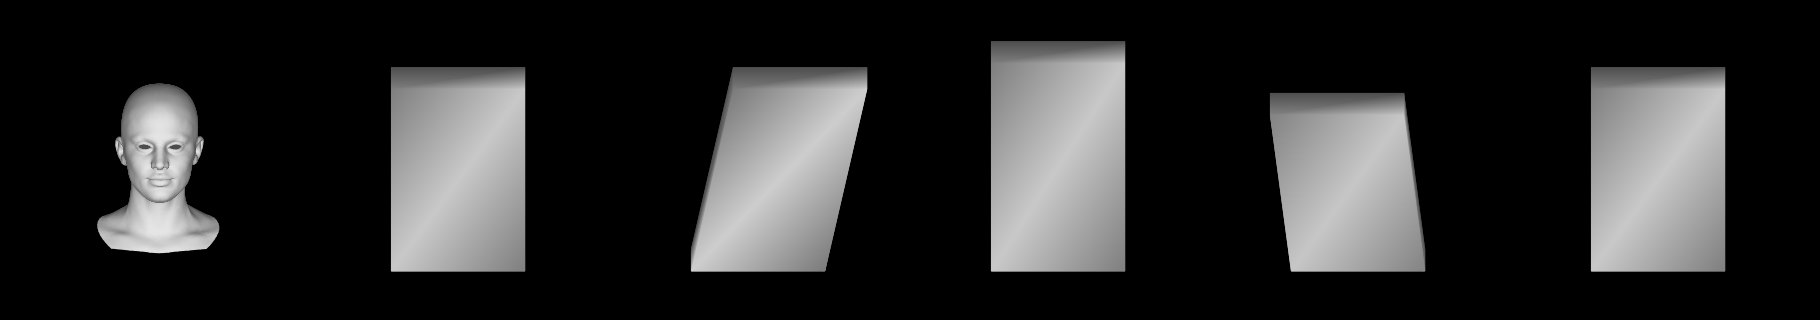

In [5]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

v_list=[ src_mesh.v, control_mesh.v, control_mesh_v2, control_mesh_v3, control_mesh_v4, np.r_[src_mesh.v, control_mesh.v]]
f_list=[ src_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, control_mesh.f, np.r_[src_mesh.f, control_mesh.f+src_mesh.f.max()+1]]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

## Mean Value Coordinate function
Really slow implementation --> can be accelerated in batch processing

In [11]:
def MVC(src_mesh, control_mesh, _func_=None, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        _func_ (np.ndarry, optional): function on control mesh vertex to interpolate. Defaults to None.
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: new vertices for source mesh
    """
    
    if _func_ is None:
        _func_ = control_mesh.v

    # new_v = np.zeros_like(src_mesh.v)
    
    new_F = np.zeros_like(src_mesh.v)
    new_W = np.zeros(src_mesh.v.shape[0])
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
            
            # if dj[jdx] < eps:
            #     new_v[vdx] = _func_[jdx]
                
            Uj[jdx] = Pj_v / dj[jdx]
        
        # Wj = np.zeros_like((control_mesh.v))
        for tri_idx in control_mesh.f:
            
            f0, f1, f2 = _func_[tri_idx]
            i0, i1, i2 = tri_idx
            
            # print(i0, i1, i2)
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                determinant = np.linalg.det(Uj[tri_idx])
                sign = -1 if determinant < 0 else 1
                
                s0 = sign * np.sqrt(1-c0**2)
                s1 = sign * np.sqrt(1-c1**2)
                s2 = sign * np.sqrt(1-c2**2)
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_F[vdx] += (W0 * f0) + (W1 * f1) + (W2 * f2)
                new_W[vdx] += W0 + W1 + W2
    return new_F / new_W[..., None]


def MVC_weight(src_mesh, control_mesh, eps=1e-8):
    """_summary_

    Args:
        src_mesh (easydict): simple dict for source mesh attributes
        control_mesh (easydict): simple dict for control mesh attributes
        eps (float, optional): threshold. Defaults to 1e-8.

    Returns:
        np.ndarry: weight to control mesh vertices for each source vertex
    """
    
    new_W = np.zeros((src_mesh.v.shape[0], control_mesh.f.shape[0], 3))
    
    for vdx, x in enumerate(src_mesh.v):
        
        Uj = np.zeros_like((control_mesh.v))
        dj = np.zeros(control_mesh.v.shape[0])
        
        for jdx, Pj in enumerate(control_mesh.v):
            
            Pj_v = Pj - x
            
            dj[jdx] = np.linalg.norm(Pj_v)
                            
            Uj[jdx] = Pj_v / dj[jdx]
        
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            i0, i1, i2 = tri_idx
            
            d0 = dj[i0]
            d1 = dj[i1]
            d2 = dj[i2]
            
            L0 = np.linalg.norm(Uj[i1] - Uj[i2])
            L1 = np.linalg.norm(Uj[i2] - Uj[i0])
            L2 = np.linalg.norm(Uj[i0] - Uj[i1])
            
            theta0 = 2 * np.arcsin(L0 * 0.5)
            theta1 = 2 * np.arcsin(L1 * 0.5)
            theta2 = 2 * np.arcsin(L2 * 0.5)
            
            h = (theta0 + theta1 + theta2) * 0.5
            
            if abs(np.pi - h) < eps:
                W0 = np.sin(theta0)*d2*d1
                W1 = np.sin(theta0)*d2*d1
                W2 = np.sin(theta0)*d2*d1
                
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
            else:
                s_theta0 = np.sin(theta0)
                s_theta1 = np.sin(theta1)
                s_theta2 = np.sin(theta2)
                
                c0 = (2.0*np.sin(h)*np.sin(h-theta0)) / (s_theta1*s_theta2) - 1
                c1 = (2.0*np.sin(h)*np.sin(h-theta1)) / (s_theta2*s_theta0) - 1
                c2 = (2.0*np.sin(h)*np.sin(h-theta2)) / (s_theta0*s_theta1) - 1
                
                s0 = np.abs(np.sqrt(1-c0**2))
                s1 = np.abs(np.sqrt(1-c1**2))
                s2 = np.abs(np.sqrt(1-c2**2))
                
                W0 = 0 if s0 == 0 else (theta0 - c1*theta2 - c2*theta1) / (2 * s1 * s_theta2 * d0)
                W1 = 0 if s1 == 0 else (theta1 - c2*theta0 - c0*theta2) / (2 * s2 * s_theta0 * d1)
                W2 = 0 if s2 == 0 else (theta2 - c0*theta1 - c1*theta0) / (2 * s0 * s_theta1 * d2)
                    
                new_W[vdx][tdx][0] = W0
                new_W[vdx][tdx][1] = W1
                new_W[vdx][tdx][2] = W2
    return new_W

def apply_MVC_weight(new_W, control_mesh, _func_=None):
    new_V = np.zeros((src_mesh.v.shape[0], 3))
    new_VW = np.zeros((src_mesh.v.shape[0]))
    
    for vdx in range(new_W.shape[0]):
        for tdx, tri_idx in enumerate(control_mesh.f):
            
            f0, f1, f2 = _func_[tri_idx]
            
            new_V[vdx] += (new_W[vdx][tdx][0] * f0) + (new_W[vdx][tdx][1] * f1) + (new_W[vdx][tdx][2] * f2)
            new_VW[vdx] += new_W[vdx][tdx].sum(0)
            
    new_V = new_V / new_VW[...,None]
    return new_V

In [12]:

def MVC_weight_batch(src_v, cage_v, cage_f, eps=1e-8):
    V = src_v.shape[0]
    F = cage_f.shape[0]
    
    # cage vertices per face
    i0 = cage_f[:, 0]
    i1 = cage_f[:, 1]
    i2 = cage_f[:, 2]

    P0 = cage_v[i0]  # (F, 3)
    P1 = cage_v[i1]
    P2 = cage_v[i2]

    # Expand to (V, F, 3)
    X = src_v[:, None, :]  # (V, 1, 3)
    D0 = P0[None, :, :] - X  # (V, F, 3)
    D1 = P1[None, :, :] - X
    D2 = P2[None, :, :] - X

    d0 = np.linalg.norm(D0, axis=-1) + eps
    d1 = np.linalg.norm(D1, axis=-1) + eps
    d2 = np.linalg.norm(D2, axis=-1) + eps

    U0 = D0 / d0[..., None]
    U1 = D1 / d1[..., None]
    U2 = D2 / d2[..., None]

    # angles
    L0 = np.linalg.norm(U1 - U2, axis=-1)
    L1 = np.linalg.norm(U2 - U0, axis=-1)
    L2 = np.linalg.norm(U0 - U1, axis=-1)

    theta0 = 2 * np.arcsin(np.clip(L0 * 0.5, -1.0, 1.0))
    theta1 = 2 * np.arcsin(np.clip(L1 * 0.5, -1.0, 1.0))
    theta2 = 2 * np.arcsin(np.clip(L2 * 0.5, -1.0, 1.0))

    h = 0.5 * (theta0 + theta1 + theta2)

    near_pi = np.abs(np.pi - h) < eps
    not_near_pi = ~near_pi

    s_theta0 = np.sin(theta0)
    s_theta1 = np.sin(theta1)
    s_theta2 = np.sin(theta2)

    c0 = (2 * np.sin(h) * np.sin(h - theta0)) / (s_theta1 * s_theta2 + eps) - 1
    c1 = (2 * np.sin(h) * np.sin(h - theta1)) / (s_theta2 * s_theta0 + eps) - 1
    c2 = (2 * np.sin(h) * np.sin(h - theta2)) / (s_theta0 * s_theta1 + eps) - 1

    s0 = np.abs(np.sqrt(np.clip(1 - c0**2, 0, 1)))
    s1 = np.abs(np.sqrt(np.clip(1 - c1**2, 0, 1)))
    s2 = np.abs(np.sqrt(np.clip(1 - c2**2, 0, 1)))

    W0 = np.zeros((V, F))
    W1 = np.zeros((V, F))
    W2 = np.zeros((V, F))

    # near-pi: degenerate case
    sin_theta0 = np.sin(theta0)
    deg_weight = sin_theta0 * d1 * d2

    W0[near_pi] = deg_weight[near_pi]
    W1[near_pi] = deg_weight[near_pi]
    W2[near_pi] = deg_weight[near_pi]

    # general case
    num0 = (theta0 - c1 * theta2 - c2 * theta1)
    num1 = (theta1 - c2 * theta0 - c0 * theta2)
    num2 = (theta2 - c0 * theta1 - c1 * theta0)

    denom0 = 2 * s1 * s_theta2 * d0
    denom1 = 2 * s2 * s_theta0 * d1
    denom2 = 2 * s0 * s_theta1 * d2

    W0[not_near_pi] = num0[not_near_pi] / (denom0[not_near_pi] + eps)
    W1[not_near_pi] = num1[not_near_pi] / (denom1[not_near_pi] + eps)
    W2[not_near_pi] = num2[not_near_pi] / (denom2[not_near_pi] + eps)

    # stack to (V, F, 3)
    return np.stack([W0, W1, W2], axis=-1)


def apply_MVC_weight_batch(W, cage_f, cage_function, eps=1e-8):
    """
    Args:
        W: (V, F, 3) array of MVC weights
        cage_f: (F, 3) array of face indices
        cage_function: (Nc, 3) array of cage vertex attributes (e.g., position, displacement)
    
    Returns:
        new_V: (V, 3) array of interpolated vertex values
    """
    V, F, _ = W.shape

    # Get cage function values per face vertex (F, 3, 3)
    tri_values = cage_function[cage_f]  # (F, 3, 3)

    # Broadcast to (V, F, 3, 3)
    tri_values = np.broadcast_to(tri_values[None, :, :, :], (V, F, 3, 3))  # (V, F, 3, 3)
    W_exp = W[..., None]  # (V, F, 3, 1)

    weighted_sum = (W_exp * tri_values).sum(axis=2)  # (V, F, 3)
    total = weighted_sum.sum(axis=1)  # (V, 3)

    weight_sum = W.sum(axis=(1, 2), keepdims=True)  # (V, 1, 1)
    weight_sum = np.clip(weight_sum, eps, np.inf)

    result = total / weight_sum.squeeze(-1)  # (V, 3)
    return result

## torch version

In [23]:
def MVC_weight_batch_torch(src_v, cage_v, cage_f, eps=1e-8):
    """
    Compute Mean Value Coordinates weights in batch (PyTorch version).

    Args:
        src_v (Tensor): (V, 3) source points
        cage_v (Tensor): (Nc, 3) cage/control points
        cage_f (Tensor): (F, 3) triangle indices of cage faces
        eps (float): numerical stability epsilon

    Returns:
        Tensor: (V, Nc, 3) weights per face per source point
    """
    V = src_v.shape[0]
    F = cage_f.shape[0]

    # face vertex indices
    i0, i1, i2 = cage_f[:, 0], cage_f[:, 1], cage_f[:, 2]

    P0 = cage_v[i0]  # (F, 3)
    P1 = cage_v[i1]
    P2 = cage_v[i2]

    # Expand to (V, F, 3)
    X = src_v[:, None, :]  # (V, 1, 3)
    D0 = P0[None, :, :] - X  # (V, F, 3)
    D1 = P1[None, :, :] - X
    D2 = P2[None, :, :] - X

    d0 = D0.norm(dim=-1).clamp(min=eps)
    d1 = D1.norm(dim=-1).clamp(min=eps)
    d2 = D2.norm(dim=-1).clamp(min=eps)

    U0 = D0 / d0[..., None]
    U1 = D1 / d1[..., None]
    U2 = D2 / d2[..., None]

    # angles
    L0 = (U1 - U2).norm(dim=-1)
    L1 = (U2 - U0).norm(dim=-1)
    L2 = (U0 - U1).norm(dim=-1)

    theta0 = 2 * torch.arcsin(torch.clamp(L0 * 0.5, -1.0, 1.0))
    theta1 = 2 * torch.arcsin(torch.clamp(L1 * 0.5, -1.0, 1.0))
    theta2 = 2 * torch.arcsin(torch.clamp(L2 * 0.5, -1.0, 1.0))

    h = 0.5 * (theta0 + theta1 + theta2)

    near_pi = torch.abs(torch.pi - h) < eps
    not_near_pi = ~near_pi

    s_theta0 = torch.sin(theta0)
    s_theta1 = torch.sin(theta1)
    s_theta2 = torch.sin(theta2)

    c0 = (2 * torch.sin(h) * torch.sin(h - theta0)) / (s_theta1 * s_theta2 + eps) - 1
    c1 = (2 * torch.sin(h) * torch.sin(h - theta1)) / (s_theta2 * s_theta0 + eps) - 1
    c2 = (2 * torch.sin(h) * torch.sin(h - theta2)) / (s_theta0 * s_theta1 + eps) - 1

    s0 = torch.sqrt(torch.clamp(1 - c0**2, 0, 1))
    s1 = torch.sqrt(torch.clamp(1 - c1**2, 0, 1))
    s2 = torch.sqrt(torch.clamp(1 - c2**2, 0, 1))

    # Output weight containers
    W0 = torch.zeros((V, F), dtype=src_v.dtype, device=src_v.device)
    W1 = torch.zeros((V, F), dtype=src_v.dtype, device=src_v.device)
    W2 = torch.zeros((V, F), dtype=src_v.dtype, device=src_v.device)

    # degenerate: h == pi
    sin_theta0 = torch.sin(theta0)
    deg_weight = sin_theta0 * d1 * d2

    W0[near_pi] = deg_weight[near_pi]
    W1[near_pi] = deg_weight[near_pi]
    W2[near_pi] = deg_weight[near_pi]

    # general case
    num0 = (theta0 - c1 * theta2 - c2 * theta1)
    num1 = (theta1 - c2 * theta0 - c0 * theta2)
    num2 = (theta2 - c0 * theta1 - c1 * theta0)

    denom0 = 2 * s1 * s_theta2 * d0
    denom1 = 2 * s2 * s_theta0 * d1
    denom2 = 2 * s0 * s_theta1 * d2

    W0[not_near_pi] = num0[not_near_pi] / (denom0[not_near_pi] + eps)
    W1[not_near_pi] = num1[not_near_pi] / (denom1[not_near_pi] + eps)
    W2[not_near_pi] = num2[not_near_pi] / (denom2[not_near_pi] + eps)

    # stack weights
    return torch.stack([W0, W1, W2], dim=-1)  # (V, Nc, 3)



def apply_MVC_weight_batch_torch(W, cage_f, cage_function, eps=1e-8):
    """
    Args:
        W: (V, F, 3) tensor of MVC weights
        cage_f: (F, 3) LongTensor of face indices
        cage_function: (Nc, 3) tensor of control values (e.g., positions or attributes)
    
    Returns:
        interpolated: (V, 3) tensor
    """
    V, F, _ = W.shape
    device = W.device

    # Get function values per triangle vertex: (F, 3, 3)
    # [F, 3] index -> [F, 3, 3]
    tri_values = cage_function[cage_f]  # (F, 3, 3)

    # Broadcast to (V, F, 3, 3): function value per source-vertex and triangle
    tri_values = tri_values.unsqueeze(0).expand(V, -1, -1, -1)  # (V, F, 3, 3)
    weights = W.unsqueeze(-1)                                   # (V, F, 3, 1)

    weighted_sum = (weights * tri_values).sum(dim=2)  # (V, F, 3)
    total = weighted_sum.sum(dim=1)                   # (V, 3)
    
    weight_sum = W.sum(dim=(1,2), keepdim=True).clamp(min=eps)  # (V, 1, 1)
    result = total / weight_sum.squeeze(-1)                     # (V, 3)

    return result

def apply_MVC_weight_batch_torch_to_deformed_cage(W, cage_f, deformed_cages, eps=1e-8):
    """
    Apply fixed MVC weights (V, F, 3) to batch of deformed cages (B, Nc, 3)

    Args:
        W (Tensor): (V, F, 3) fixed MVC weights
        cage_f (LongTensor): (F, 3) triangle indices
        deformed_cages (Tensor): (B, Nc, 3) batch of deformed cage positions

    Returns:
        Tensor: (B, V, 3) deformed target mesh per batch
    """
    B, Nc, _ = deformed_cages.shape
    V, F, _ = W.shape
    device = deformed_cages.device

    # Get face-wise cage values: (B, F, 3, 3)
    tri_values = deformed_cages[:, cage_f]  # (B, F, 3, 3)

    # Broadcast weights: (1, V, F, 3, 1)
    weights = W[None, :, :, :, None]  # add batch dim, and vector dim

    # Broadcast tri_values: (B, 1, F, 3, 3)
    tri_values = tri_values[:, None, :, :, :]

    # Multiply and sum: (B, V, F, 3)
    weighted_sum = (weights * tri_values).sum(dim=3)

    # Final sum over F: (B, V, 3)
    total = weighted_sum.sum(dim=2)

    # Normalize per vertex
    weight_sum = W.sum(dim=(1, 2), keepdim=True).clamp(min=eps)  # (V, 1, 1)
    result = total / weight_sum.transpose(0, 1)  # (B, V, 3)

    return result

In [ ]:
def compute_MVC_vertexwise(src_v, cage_v, cage_f, eps=1e-8):
    """
    Compute Mean Value Coordinates per cage vertex for each mesh vertex

    Args:
        src_v (torch.tensor): (V, 3) source points
        cage_v (torch.tensor): (Nc, 3) cage/control points
        cage_f (torch.tensor): (F, 3) triangle indices of cage faces
        eps (float): numerical stability epsilon

    Returns:
        weights per cage vertex (V, Nc)
    """
    V = src_v.shape[0]
    Nc = cage_v.shape[0]
    F = cage_f.shape[0]

    # Get cage face vertices
    i0, i1, i2 = cage_f[:, 0], cage_f[:, 1], cage_f[:, 2]
    P0 = cage_v[i0]  # (F, 3)
    P1 = cage_v[i1]
    P2 = cage_v[i2]

    X = src_v[:, None, :]  # (V, 1, 3)

    D0 = P0[None, :, :] - X  # (V, F, 3)
    D1 = P1[None, :, :] - X
    D2 = P2[None, :, :] - X

    # clamp min by eps to prevent division by 0
    d0 = D0.norm(dim=-1).clamp(min=eps)
    d1 = D1.norm(dim=-1).clamp(min=eps)
    d2 = D2.norm(dim=-1).clamp(min=eps)

    U0 = D0 / d0[..., None]
    U1 = D1 / d1[..., None]
    U2 = D2 / d2[..., None]

    # compute angles between normalized directions
    L0 = (U1 - U2).norm(dim=-1)
    L1 = (U2 - U0).norm(dim=-1)
    L2 = (U0 - U1).norm(dim=-1)

    theta0 = 2 * torch.arcsin(torch.clamp(L0 * 0.5, -0.999999, 0.999999))
    theta1 = 2 * torch.arcsin(torch.clamp(L1 * 0.5, -0.999999, 0.999999))
    theta2 = 2 * torch.arcsin(torch.clamp(L2 * 0.5, -0.999999, 0.999999))
    h = 0.5 * (theta0 + theta1 + theta2)

    near_pi = torch.abs(torch.pi - h) < eps
    not_near_pi = ~near_pi

    s_theta0 = torch.sin(theta0)
    s_theta1 = torch.sin(theta1)
    s_theta2 = torch.sin(theta2)

    # added eps to prevent division by 0
    c0 = (2 * torch.sin(h) * torch.sin(h - theta0)) / (s_theta1 * s_theta2 + eps) - 1
    c1 = (2 * torch.sin(h) * torch.sin(h - theta1)) / (s_theta2 * s_theta0 + eps) - 1
    c2 = (2 * torch.sin(h) * torch.sin(h - theta2)) / (s_theta0 * s_theta1 + eps) - 1

    # added eps to prevent sqrt(0)
    s0 = torch.sqrt(torch.clamp(1 - c0**2, 0, 1)+eps)
    s1 = torch.sqrt(torch.clamp(1 - c1**2, 0, 1)+eps)
    s2 = torch.sqrt(torch.clamp(1 - c2**2, 0, 1)+eps)

    # triangle-wise weights (V, F)
    W0 = torch.zeros((V, F), dtype=src_v.dtype, device=src_v.device)
    W1 = torch.zeros_like(W0)
    W2 = torch.zeros_like(W0)

    deg_weight = s_theta0 * d1 * d2
    W0[near_pi] = deg_weight[near_pi]
    W1[near_pi] = deg_weight[near_pi]
    W2[near_pi] = deg_weight[near_pi]

    num0 = (theta0 - c1 * theta2 - c2 * theta1)
    num1 = (theta1 - c2 * theta0 - c0 * theta2)
    num2 = (theta2 - c0 * theta1 - c1 * theta0)

    denom0 = 2 * s1 * s_theta2 * d0
    denom1 = 2 * s2 * s_theta0 * d1
    denom2 = 2 * s0 * s_theta1 * d2

    # added eps to prevent division by 0
    W0[not_near_pi] = num0[not_near_pi] / (denom0[not_near_pi] + eps)
    W1[not_near_pi] = num1[not_near_pi] / (denom1[not_near_pi] + eps)
    W2[not_near_pi] = num2[not_near_pi] / (denom2[not_near_pi] + eps)

    # Final (V, Nc) weight matrix
    W_vert = torch.zeros((V, Nc), dtype=src_v.dtype, device=src_v.device)
    W_vert.index_add_(1, i0, W0)
    W_vert.index_add_(1, i1, W1)
    W_vert.index_add_(1, i2, W2)

    # Normalize to ensure partition of unity
    W_vert = W_vert / (W_vert.sum(dim=1, keepdim=True) + eps)

    return W_vert  # (V, Nc)

# Run

### all in one

In [ ]:
new_v = MVC(src_mesh, control_mesh, control_mesh_v2)

In [12]:
abs(np.pi - 1.5761573564070206) < 1e-3

False

### save weight and apply later

In [13]:
new_w = MVC_weight(src_mesh, control_mesh)
new_w.shape


(11248, 12, 3)

In [20]:
new_w2 = MVC_weight_batch(src_mesh.v, control_mesh.v, control_mesh.f)
new_w2.shape


(11248, 12, 3)

In [29]:
new_v2 = apply_MVC_weight(new_w, control_mesh, control_mesh_v2)
new_v22 = apply_MVC_weight(new_w2, control_mesh, control_mesh_v2)

In [36]:
new_v3 = apply_MVC_weight_batch(new_w2, control_mesh.f, control_mesh_v2)

In [31]:
print(src_mesh.v.min(0), src_mesh.v.max(0))
# print(new_v.min(0), new_v.max(0))
print(new_v2.min(0), new_v2.max(0))
print(new_v22.min(0), new_v22.max(0))

[-1.18697512 -1.81234658 -1.37132633] [1.12008107 1.3834517  0.78344184]
[-1.05129244 -1.81234658 -1.37132633] [1.33846999 1.3834517  0.78344184]
[-1.05129232 -1.81234648 -1.37132621] [1.33846994 1.38345158 0.78344158]


## torch

In [29]:
# deformed_cages = torch.vstack([
#     torch.tensor(control_mesh.v)[None],
#     torch.tensor(control_mesh.v)[None],
#     torch.tensor(control_mesh.v)[None]
# ])
deformed_cages = torch.vstack([
    torch.tensor(control_mesh_v2)[None],
    torch.tensor(control_mesh_v3)[None],
    torch.tensor(control_mesh_v4)[None]
])
print(deformed_cages.shape)

torch.Size([3, 8, 3])


In [33]:
new_w3_th=compute_MVC_vertexwise(torch.tensor(src_mesh.v), torch.tensor(control_mesh.v), torch.tensor(control_mesh.f).long())
new_w3_th.shape

torch.Size([11248, 8])

In [34]:
print(new_w3_th.shape, deformed_cages.shape)
new_v4_th = new_w3_th @ deformed_cages
new_v4_th.shape

torch.Size([11248, 8]) torch.Size([3, 8, 3])


torch.Size([3, 11248, 3])

In [8]:
new_w2_th = MVC_weight_batch_torch(
    torch.tensor(src_mesh.v), torch.tensor(control_mesh.v), torch.tensor(control_mesh.f).long()
)
print(new_w2_th.shape)
# new_v3_th = apply_MVC_weight_batch(
#     new_w2_th, torch.tensor(control_mesh.f).long(), torch.tensor(control_mesh_v2)
# )
# print(new_v3_th.shape)

print(new_w2_th.shape, torch.tensor(control_mesh.f).long().shape, deformed_cages.shape)
new_v4_th = apply_MVC_weight_batch_torch_to_deformed_cage(new_w2_th, torch.tensor(control_mesh.f).long(), deformed_cages)
# print(new_v4_th.shape)

torch.Size([11248, 12, 3])
torch.Size([11248, 12, 3]) torch.Size([12, 3]) torch.Size([3, 8, 3])


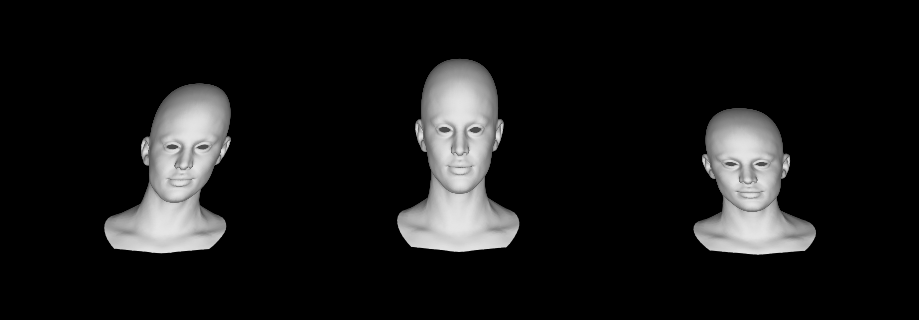

In [35]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        new_v4_th[0],
        new_v4_th[1],
        new_v4_th[2],
        ]
f_list=[ 
        src_mesh.f,
        src_mesh.f,
        src_mesh.f,
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

## Visualize

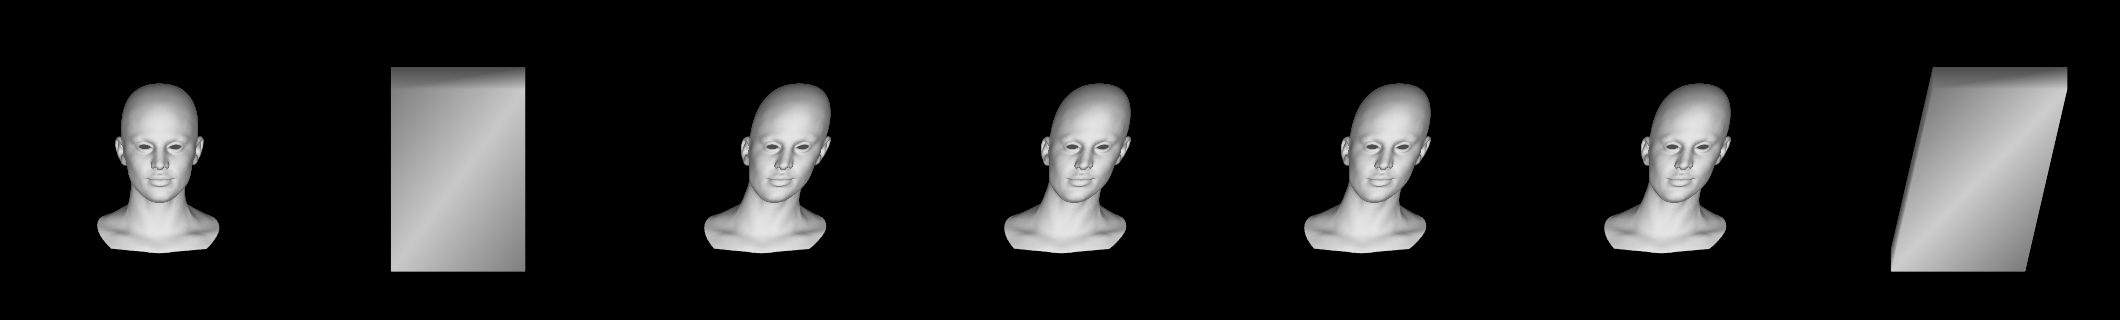

In [46]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        new_v2, 
        new_v22, 
        new_v3, 
        new_v3_th.numpy(),
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        src_mesh.f,
        src_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

In [ ]:

from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms


def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def area_of_polygon(verts):
        # 각 spherical triangle의 면적 계산 (Girard's theorem 사용)
        def angle(a, b):
            return np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

        total_area = 0.0
        for i in range(1, len(verts) - 1):
            a = verts[0]
            b = verts[i]
            c = verts[i + 1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            # spherical excess
            excess = alpha + beta + gamma - np.pi
            total_area += excess
        return total_area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = area_of_polygon(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_weights(v0, cage_vertices, cage_function):
    sphere_points, directions, norms = project_to_unit_sphere(v0, cage_vertices)
    weights = compute_spherical_voronoi_area(sphere_points)
    weights /= np.sum(weights)  # normalize

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output

def cage_based_interpolation(target_vertices, cage_vertices, cage_function):
    outputs = []
    for v0 in target_vertices:
        out = interpolate_using_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
    return np.array(outputs)


#############


import numpy as np
from scipy.spatial import SphericalVoronoi

def project_to_unit_sphere(v0, cage_vertices):
    directions = cage_vertices - v0[None, :]
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    sphere_points = directions / norms
    return sphere_points, directions, norms.squeeze()

def compute_spherical_voronoi_area(sphere_points):
    sv = SphericalVoronoi(sphere_points, radius=1.0, center=np.array([0., 0., 0.]))
    sv.sort_vertices_of_regions()

    def angle(u, v):
        return np.arccos(np.clip(np.dot(u, v), -1.0, 1.0))

    def spherical_polygon_area(verts):
        # triangulate with fan method
        area = 0.0
        for i in range(1, len(verts) - 1):
            a, b, c = verts[0], verts[i], verts[i+1]
            alpha = angle(b, c)
            beta = angle(c, a)
            gamma = angle(a, b)
            excess = alpha + beta + gamma - np.pi
            area += excess
        return area

    areas = []
    for region in sv.regions:
        verts = sv.vertices[region]
        area = spherical_polygon_area(verts)
        areas.append(area)
    return np.array(areas)

def interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function, eps=1e-8):
    sphere_points, directions, distances = project_to_unit_sphere(v0, cage_vertices)
    areas = compute_spherical_voronoi_area(sphere_points)
    volumes = (1/3) * areas * distances  # cone volumes

    volumes = np.maximum(volumes, eps)  # ensure non-zero
    weights = volumes / np.sum(volumes)

    offset_sum = np.sum(weights[:, None] * (cage_vertices - v0), axis=0)
    zero_check = np.linalg.norm(offset_sum)

    output = np.sum(weights[:, None] * cage_function, axis=0)
    return output, weights, offset_sum, zero_check

def cage_interpolation_cone_method(target_vertices, cage_vertices, cage_function):
    outputs, all_weights, all_checks = [], [], []
    for v0 in target_vertices:
        out, w, offset, norm_check = interpolate_using_cone_volume_weights(v0, cage_vertices, cage_function)
        outputs.append(out)
        all_weights.append(w)
        all_checks.append(norm_check)
    return np.array(outputs), np.array(all_weights), np.array(all_checks)


In [31]:
output = cage_based_interpolation(src_mesh.v, control_mesh.v, control_mesh_v2)

# output2 = cage_interpolation_cone_method(src_mesh.v, control_mesh.v, control_mesh_v2)


In [30]:
# print(output2[1], output2[2])

[[2.49802974e-01 4.76081308e-02 1.79420329e-01 ... 9.38144764e-02
  1.92847058e-01 1.01489131e-09]
 [2.43638093e-01 5.33469882e-02 1.76273986e-01 ... 9.35072418e-02
  1.91775181e-01 1.01325429e-09]
 [2.48033272e-01 4.91658302e-02 1.78476283e-01 ... 9.30644282e-02
  1.92970363e-01 1.01405411e-09]
 ...
 [6.73587097e-02 2.11859283e-01 9.86086542e-10 ... 1.50162822e-01
  9.51249911e-02 1.68019646e-01]
 [4.19428202e-02 2.14076221e-01 9.87369198e-10 ... 1.62962084e-01
  1.02151173e-01 1.63965198e-01]
 [1.90511882e-02 2.15257629e-01 9.93278857e-10 ... 1.76618831e-01
  1.09128652e-01 1.57270118e-01]] [0.31477486 0.30695969 0.31292799 ... 1.10993081 1.00910788 0.91695508]


# just for fun test 

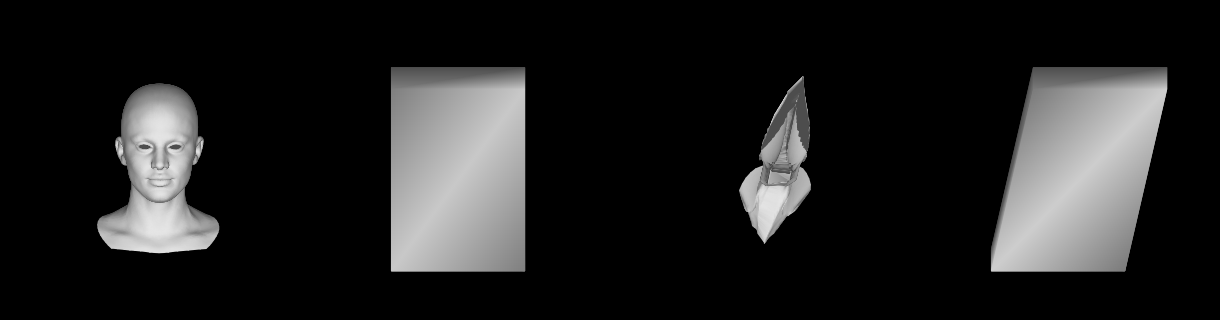

In [29]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output[0],
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')

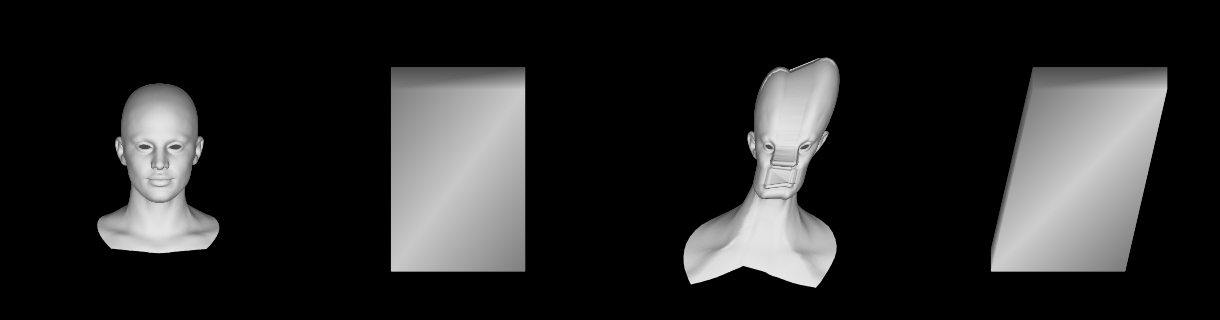

In [24]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .35

# v_list=[ src_mesh.v, new_v, control_mesh.v, control_mesh.v*1.2-control_mesh_v12_mean+control_mesh_v_mean]
v_list=[ 
        src_mesh.v, 
        control_mesh.v, 
        # new_v, 
        output,
        control_mesh_v2
        ]
f_list=[ 
        src_mesh.f,
        control_mesh.f,
        src_mesh.f,
        control_mesh.f
        ]

# xyz Euler angle to rotate the mesh
rot_list=[ [10,0,0] ]*len(v_list)

plot_mesh_gouraud(v_list, f_list, 
                     # is_diff=True, diff_base=src_mesh.v, #diff_revert=True,
                     mesh_scale=mesh_scale,
                     rot_list=rot_list, size=SIZE, mode='shade')